<a href="https://colab.research.google.com/github/JohanEstebanCuervo/Comunicaciones_Digitales/blob/main/Quadrature_Amplitude_Modulation_(QAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias a utilizar

In [1]:
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg 
from math import ceil,floor
from commpy.modulation import QAMModem
from commpy.filters import rrcosfilter
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

In [14]:
plt.style.use('ggplot')
def Grafica_PSD(signal,Fs,title='Espectro de Potencia'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  plt.figure(figsize=(16,9))
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title(title,fontsize = 20)
  plt.grid()
  plt.show()

def eyediagram(modulador,muestras_simbolo,title='Diagrama de ojo'):

  inicio=muestras_simbolo//2+1

  plt.figure(figsize=(20,7))
  plt.suptitle(title,fontsize = 24)
  diagramai=np.reshape(modulador.PAMi[inicio:len(modulador.PAMi)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.subplot(1,2,1)
  plt.plot(x,diagramai)
  plt.title('PAM i',fontsize = 20 )
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()

  diagramaq=np.reshape(modulador.PAMq[inicio:len(modulador.PAMq)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.subplot(1,2,2)
  plt.plot(x,diagramaq)
  plt.title('PAM q',fontsize = 20 )
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()



def Grafica_PSD_eyediagram(signal,Fs,muestras_simbolo,title='Señal'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  fig= plt.figure(figsize=(25,6))
  plt.subplot(1,2,1)
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title('Espectro de Potencia '+ title,fontsize = 20)
  plt.grid()

  plt.subplot(1,2,2)
  inicio=muestras_simbolo//2+1
  plt.title('Diagrama de ojo ' + title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()
  signal = np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

  plt.show

def Graficas_QAM(modulador):
  fig = plt.figure(figsize=(15,15))

  ################## Primer plot Bits ##########################################
  plt.subplot(6,1,1)
  markerline, stemlines, baseline =plt.stem(np.arange(1,len(modulador.bits)+1), modulador.bits, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Bits',fontsize = 14)
  xmin, xmax, _, _ = plt.axis()
  plt.grid()


  #################  Simbolo i #########################################
  plt.subplot(6,1,2)
  t_si = np.linspace(modulador.bit_grup,modulador.bit_grup*len(modulador.simboli),len(modulador.simboli))
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simboli, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos i',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()

  ####################### PAM i ######################################################
  plt.subplot(6,1,3)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMi, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM i',fontsize = 14)
  plt.grid()

  ##################### Simbolo q ############################################
  plt.subplot(6,1,4)
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simbolq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos q',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()


  ####################### PAM q ######################################################

  plt.subplot(6,1,5)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM q',fontsize = 14)
  plt.grid()

  ####################### PAM q ######################################################

  plt.subplot(6,1,6)
  plt.plot(modulador.t, modulador.signal,color='gray')
  plt.ylabel('signal',fontsize = 14)
  plt.grid()

def SNRvsErrores(modulador,Nbits,muestras=80,Repeticiones=10):
  bits = np.random.randint(0,2,Nbits) #señal de bits

  modulador.charge_bits(bits)

  table = np.zeros((muestras,2))

  for i,amp_r in enumerate(np.logspace(-1,1,muestras)):
    errores=0
    SNR=0
    
    for k in range(Repeticiones):
      #Calculo del diagrma de constelacion o de los puntos en el plano
      
      noise= amp_r*np.random.random(len(modulador.signal))-amp_r/2
      signal = modulador.signal+noise

      Diagrama = modulador.Decode_QAM(signal)
      #calculo de los bits estimados
      bits_est = modulador.Estimation_Bits(Diagrama)
      
      #Errores en la estimacion
      if len(bits_est)!=len(bits):
        bits_est=bits_est[:-(len(bits_est)-len(bits))]
      errores += np.sum(np.abs(bits_est-bits))

      #Calculo del SNR apartir del espectro de potencia

      f, Pxx_den = sg.welch(signal, modulador.Fs,nperseg=2048, nfft=2048)

      Espectro = 10*np.log10(Pxx_den)
      P_s = np.max(Espectro)
      P_ruido = np.mean(Espectro[np.where(f>2*modulador.freq_por)[:-100]])
      SNR+= P_s-P_ruido

    table[i]= [SNR/Repeticiones,errores/Repeticiones]

  return table

def grafica_SNRvsErrores(Tables,Labels):
  plt.figure(figsize=(20,10)) 
  for i,table in enumerate(Tables):
    plt.plot(table[:,0],table[:,1],label=Labels[i])

  plt.xlabel('SNR (dB)')                       #eje x
  plt.ylabel('Num Errores')                            #eje y
  plt.title('Errores vs SNR ')              #título
  plt.legend()                               #mostrar referencias
  plt.savefig("erroresvsSNR.png")               #guardar el gráfico en una imagen .png


def decimaltobin(decimal, bit_grup):

  bits=np.array([0])

  for num in decimal:

    bin = np.array(list(str("{0:b}".format(num)))).astype('int')
    if(len(bin)!=bit_grup):
      bin = np.concatenate((np.zeros(bit_grup-len(bin)),bin))

    bits= np.concatenate((bits,bin))

  return bits[1:]


In [5]:
class QAM_Modulation:

  def __init__(self,freq_por,time_bit,simbol_sample):
    self.type_PAM= 'square'    # tipo de PAM 'RRC' O 'square'
    self.bit_grup=2            # Numero de bits agrupados
    self.order_mod= 2**self.bit_grup          
    self.freq_por=freq_por
    self.time_bit=time_bit
    self.simbol_sample=simbol_sample
    self.alpha=1
    self.span_RRC=4
    self.Ts=1
    self.time_simbol= time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)
    self.cod_QAM()

  def cod_QAM(self):
    
    tam = np.sqrt(self.order_mod)
    tam_cuadricula = ceil(tam)
    point = tam_cuadricula/2-0.5
    x= np.linspace(-point,point,tam_cuadricula)
    grid = np.array(np.meshgrid(x, x)).reshape((2,-1)).T
    self.cod = grid
    if self.bit_grup%2!=0:
      if self.order_mod == 8:
        x=np.array([0,0])
        grid_list=list(grid.astype('int'))
        for i,val in enumerate(grid_list):
          if np.array_equal(x,val):
            break

        grid_list.pop(i)
        self.cod = np.array(grid_list)

      else:
        X= np.arange(len(grid)).reshape((-1,int(np.sqrt(len(grid)))))

        k = int((self.bit_grup-3)/2)
        grid2 = np.indices((k,k)).reshape((2,-1)).T

        fuera=[]
        delta=tam_cuadricula-k
        fuera.append(X[grid2[:,0],grid2[:,1]])
        fuera.append(X[grid2[:,0]+delta,grid2[:,1]])
        fuera.append(X[grid2[:,0],grid2[:,1]]+delta)
        fuera.append(X[grid2[:,0]+delta,grid2[:,1]]+delta)
        grid = np.delete(grid,fuera,0)

        self.cod = grid


    

  def charge_bits(self,bits):
    self.bits = bits
    self.decimal = self.bintodecimal(bits,self.bit_grup)
    code_QAM= self.codificacion_QAM(self.decimal)
    self.simboli = code_QAM[:,0]
    self.simbolq = code_QAM[:,1]

    if self.type_PAM == 'square':
      self.PAMi= self.Pulse_shaping_square(code_QAM[:,0],self.simbol_sample)
      self.PAMq= self.Pulse_shaping_square(code_QAM[:,1],self.simbol_sample)

    elif self.type_PAM == 'RRC':
      self.PAMi= self.Pulse_shaping_RRC(code_QAM[:,0],self.simbol_sample)
      self.PAMq= self.Pulse_shaping_RRC(code_QAM[:,1],self.simbol_sample)

    else:
      print('Type PAM equivocado o no implementado: ' + str(self.type_PAM)+'   !!!!!')

    self.t = np.linspace(0,self.time_simbol*len(self.simboli),len(self.PAMi))
    self.portadorai = np.cos(2*np.pi*self.freq_por*self.t)
    self.portadoraq = np.cos(2*np.pi*self.freq_por*self.t+np.pi/2)

    self.signal = self.PAMi*self.portadorai-self.PAMq*self.portadoraq
    
  def set_bitgrup(self,val):
    self.bit_grup=int(val)
    self.order_mod= 2**self.bit_grup
    self.time_simbol= self.time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)
    self.cod_QAM()

  def set_cod(self,cod):
    if len(cod)!= self.order_mod :
      print("Cantidad de puntos no concuerda con el numero de bits agrupados.",)

    elif len(cod[0])!=2:
      print("Cod debe tener 2 columnas | cor x | cor y | " )
    
    else:
      self.cod = cod

  def upsample(self,signal,N):

    y = np.zeros(len(signal)*N)

    for i in range(len(signal)):

      y[i*N] = signal[i]

    return y

  def codificacion_QAM(self,X):

    salto_rad=2*np.pi/self.order_mod
    ang=0

    code_PSK = np.zeros((len(X),2))

    for i in range(len(X)):
      code_PSK[i] = self.cod[self.table[X[i]]] 

    return code_PSK

  def Pulse_shaping_square(self,bits,muestras_simbolo):
    ps = np.ones(muestras_simbolo)
    bits_sample = self.upsample(bits, muestras_simbolo)

    return np.convolve(bits_sample,ps)[:-(muestras_simbolo-1)]


  def Pulse_shaping_RRC(self,bits,muestras_simbolo):
    longitud_filtro_m = self.span_RRC*muestras_simbolo  #Longitud del filtro en Muestras
    Fs = muestras_simbolo/self.Ts  #Frecuencia de muestreo
    RRC = rrcosfilter(longitud_filtro_m, alpha=self.alpha, Ts=self.Ts, Fs=Fs)

    bits_sample = self.upsample(bits, muestras_simbolo)

    inicial= int(self.span_RRC/2*muestras_simbolo)
    final = -(inicial-1)

    return np.convolve(bits_sample,RRC[1])[inicial:final]

  def bintodecimal(self,X,n,relleno='despues'):
    tam= np.shape(X)[0]
    if tam%n!=0:

      if relleno =='antes':
        X = np.concatenate((np.zeros(n-tam%n),X)).astype(int)

      if relleno =='despues':
        X = np.concatenate((X,np.zeros(n-tam%n))).astype(int)

    X = np.reshape(X,(-1,n))*2
    res = np.copy(X[:,-1])//2
    X = np.power(X,np.flip(np.arange(n)))

    X[:,-1]=X[:,-1]*res

    X = np.sum(X,axis=1).astype(int)

    return X

  def Decode_QAM(self,signal): ##  Fp -> Frecuencia Portadora. Fs -> Frecuencia de muestreo. Tb -> Tiempo de Baudio
                                  ##  Fs*Tb debe ser un numero entero  primera restricción
    #signal= signal.reshape((-1,self.simbol_sample))
    #print(np.shape(signal))
    t = np.linspace(0, len(signal)/self.Fs,len(signal))
    Portadorai = np.cos(2*np.pi*self.freq_por*t)
    Portadoraq = np.cos(2*np.pi*self.freq_por*t+np.pi/2)
    Muestras_ciclo = self.simbol_sample/(self.freq_por*self.time_simbol)
    xsig = (signal*Portadorai).reshape((-1,self.simbol_sample))
    ysig = (signal*Portadoraq).reshape((-1,self.simbol_sample))

    x = np.mean(xsig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    y = np.mean(ysig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    #print(len(x))
    #decobits1 = np.mean(np.reshape(x, (-1,int(self.Fs*self.time_simbol))),axis=1)*2
    #decobits2 = np.mean(np.reshape(y, (-1,int(self.Fs*self.time_simbol))),axis=1)*-2
    
    return np.concatenate((x,-y),axis=1)#np.reshape(np.concatenate((decobits1,decobits2)),(2,-1)).T

  def Estimation_Bits(self,Points):

    point_est = self.Point_est(Points)
    decimal = np.where(self.table==point_est.reshape((-1,1)))[1]

    return self.decimaltobin(decimal).astype('int')


  def Point_est(self,Points):

    dist = np.zeros((len(Points),self.order_mod))

    for i in range(self.order_mod):

      dist[:,i]= np.sum(np.power(Points-self.cod[i],2),axis=1)


    return np.argmin(dist,axis=1)
  
  def decimaltobin(self,decimal):

    bits=np.array([0])

    for num in decimal:

      bin = np.array(list(str("{0:b}".format(num)))).astype('int')
      if(len(bin)!=self.bit_grup):
        bin = np.concatenate((np.zeros(self.bit_grup-len(bin)),bin))

      bits= np.concatenate((bits,bin))

    return bits[1:]

#Quadrature Amplitude Modulation

Si se entiende claramente la modulación PSK. Se puede ver claramente que la modulación QAM es prácticamente lo mismo. Y está basada en los mismos principios que la modulación PSK. EL único cambio es que no se asignan puntos en una circunferencia si no en el plano. Por lo tanto se termina modulando en amplitud y fase. Pero los algoritmos de codificación y decodificación funcionan igualmente con algunos pequeños cambios.
 
**Mapeo:** Es el proceso de designar un valor de un grupo de bits a un punto en el espacio IQ.
 
**Codificación:** Es un sinónimo de mapeo.
 
**Distancia Hamming:** Es el número de bits que cambian entre dos símbolos contiguos.
 
**Curva de errores de bit vs SNR:** Gráfica que representa en el eje y el número de errores de bit cometidos en una decodificación y en el eje x la relación señal a ruido de la señal generalmente expresada en decibeles.

**Mapeo:** A diferencia de PSK el programa realizado mapea los puntos de el menor en el eje Y e izquierda a derecha. Siempre se codifica de esa manera. Y la propiedad table funciona de la misma manera que para la codificación PSK
ejemplo:

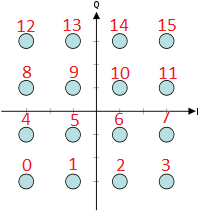

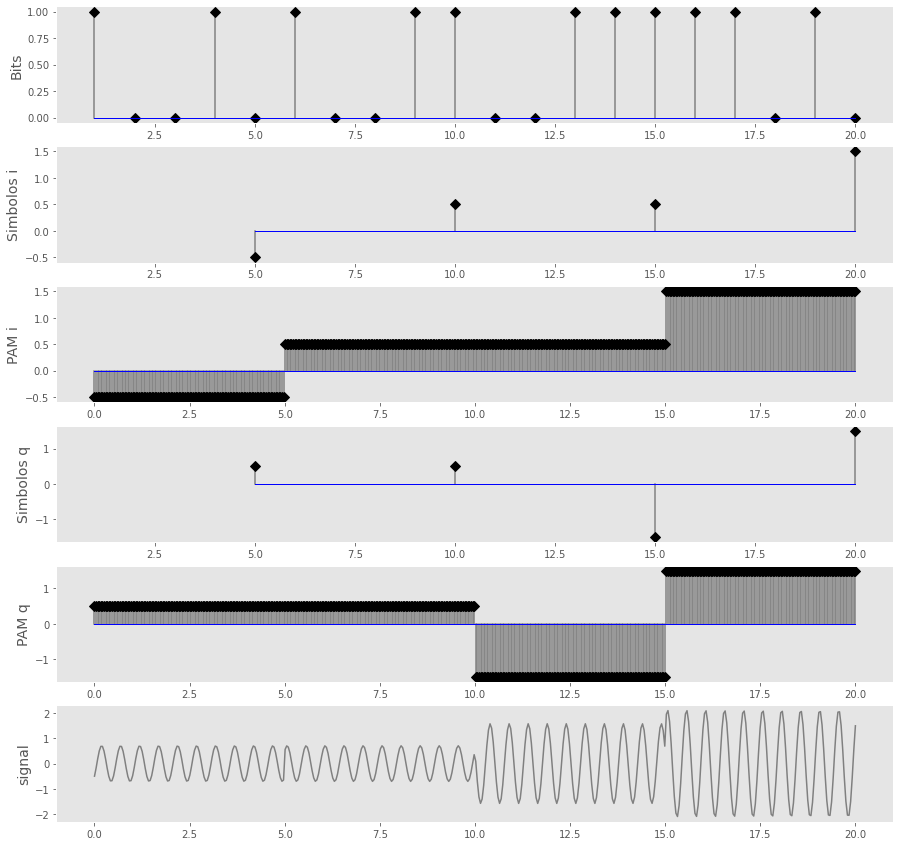

In [35]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2

bit_grup=5  # numero de bits agrupados
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.set_bitgrup(bit_grup)

modulador.alpha=0
modulador.type_PAM='square'

Nbits = 4*bit_grup #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador.charge_bits(bits)

Graficas_QAM(modulador)

Como Se puede ver Ahora hay una modulación en fase y en amplitud el cual se ve muy claro con pulsos cuadrados para las PAM. Ahora se veran los diagramas de constelación y diagramas de ojo.

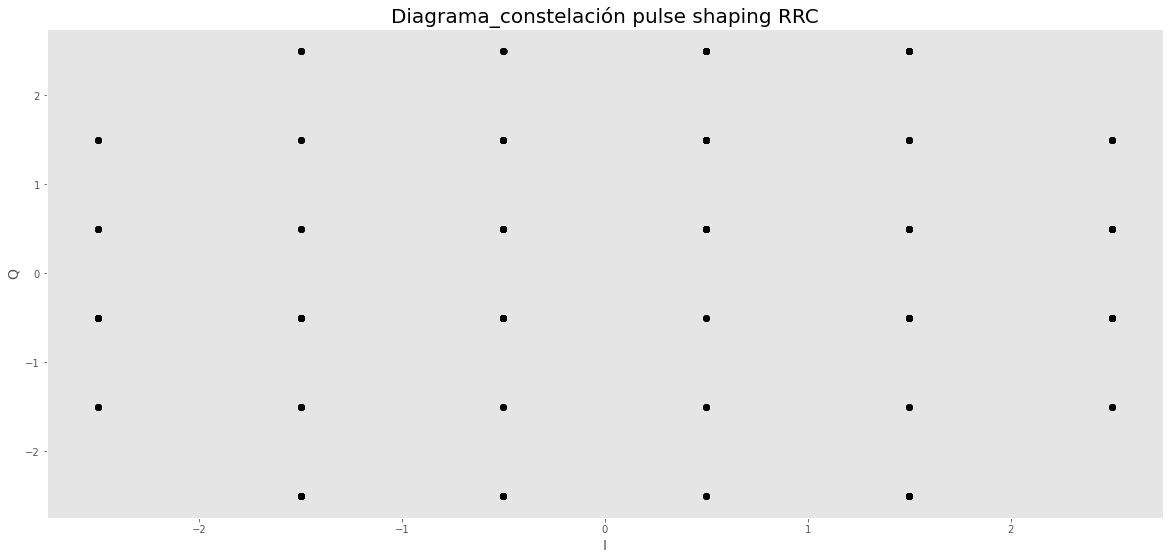

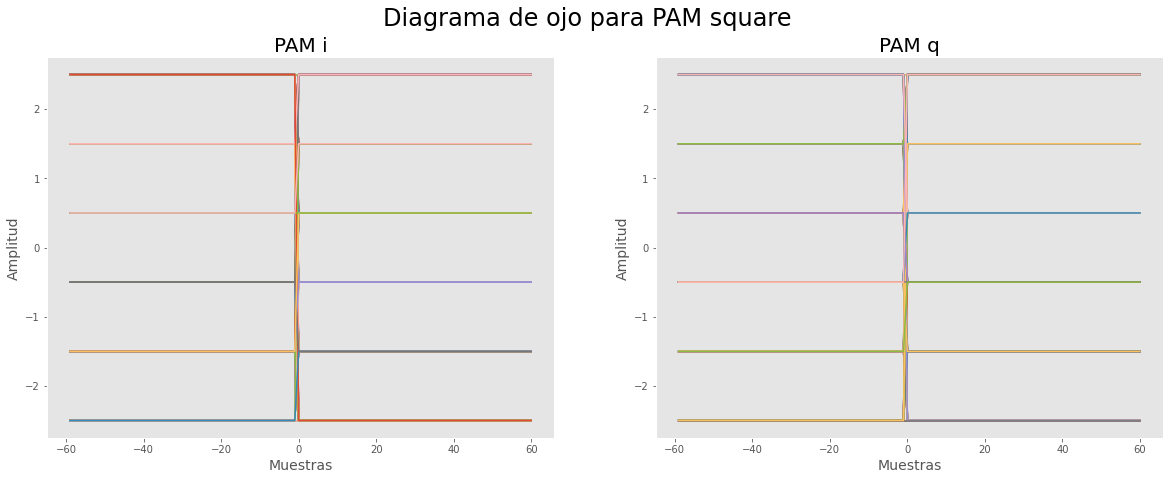

In [36]:
Nbits = 2000 #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador.charge_bits(bits)
Diagrama = modulador.Decode_QAM(modulador.signal)

plt.figure(figsize=(20,9))

#plt.subplot(1,2,1)
plt.scatter(Diagrama[:,0],Diagrama[:,1],color='black')
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelación pulse shaping RRC',fontsize = 20)
plt.grid()

eyediagram(modulador, modulador.simbol_sample, title='Diagrama de ojo para PAM square')

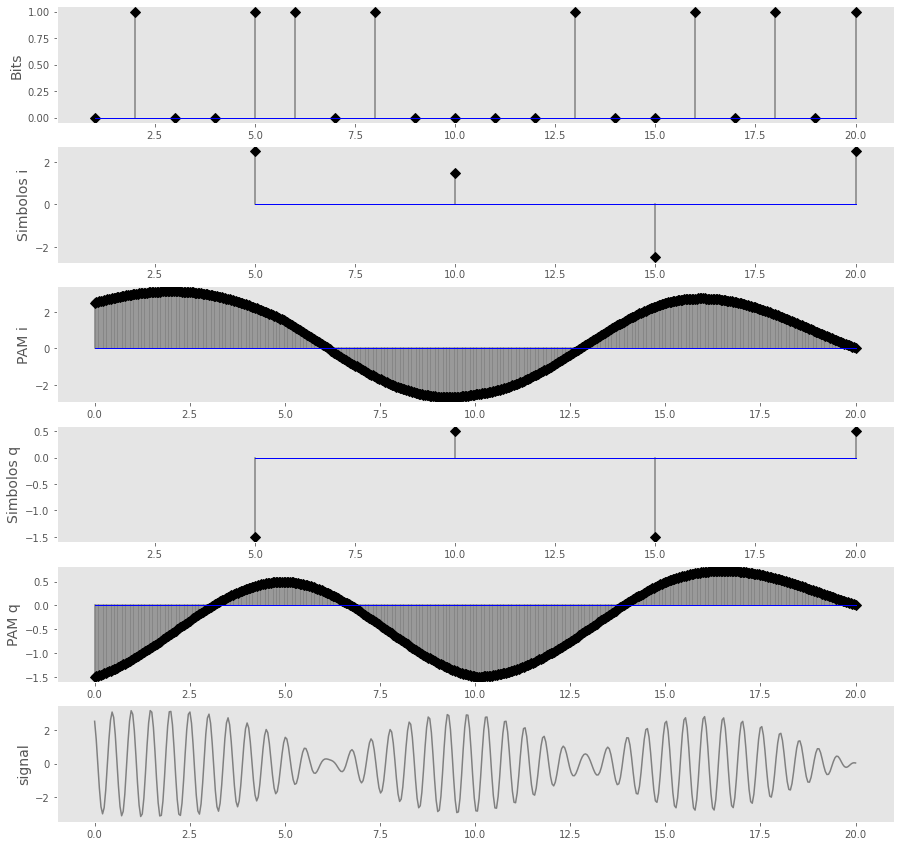

In [45]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2

bit_grup=5  # numero de bits agrupados
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.set_bitgrup(bit_grup)

modulador.alpha=0
modulador.type_PAM='RRC'

Nbits = 4*bit_grup #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador.charge_bits(bits)

Graficas_QAM(modulador)

Con el pulse shaphing RRC no existen los saltos en la señal. Son transisiones suaves.

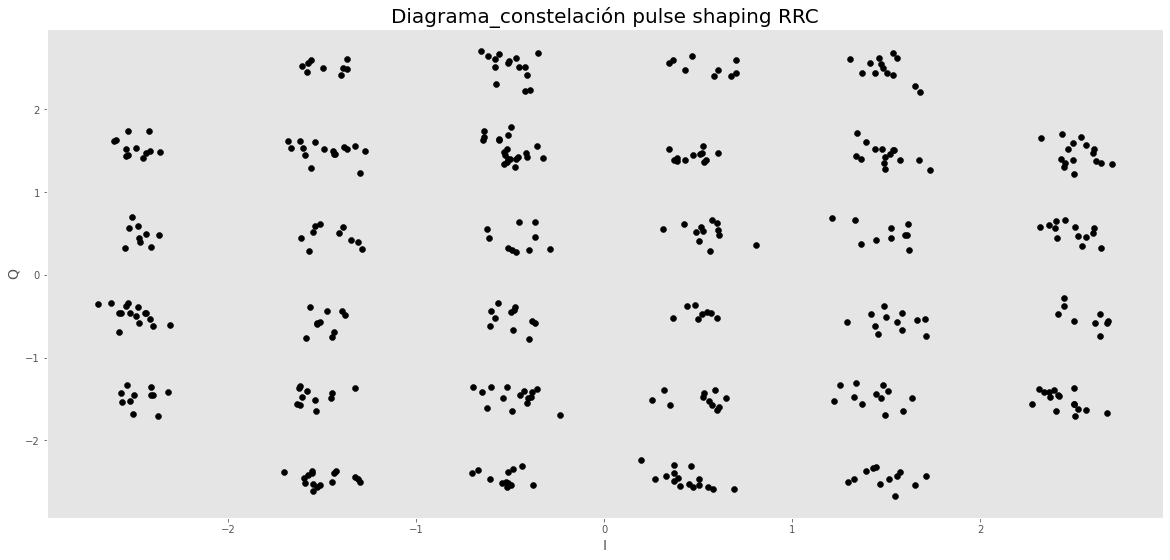

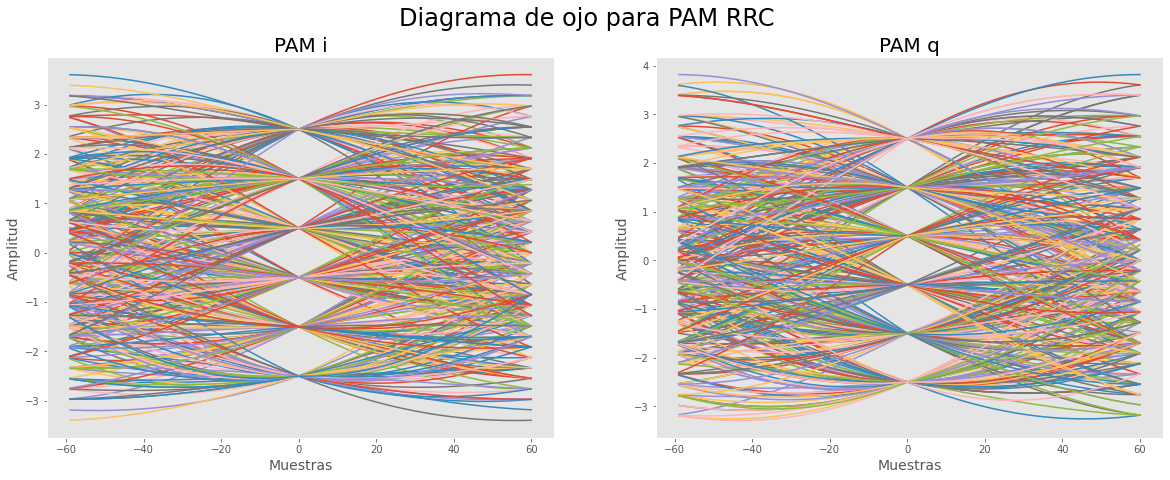

In [46]:
Nbits = 2000 #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador.charge_bits(bits)
Diagrama = modulador.Decode_QAM(modulador.signal)

plt.figure(figsize=(20,9))

#plt.subplot(1,2,1)
plt.scatter(Diagrama[:,0],Diagrama[:,1],color='black')
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelación pulse shaping RRC',fontsize = 20)
plt.grid()

eyediagram(modulador, modulador.simbol_sample, title='Diagrama de ojo para PAM RRC')

Con el filtro RRC. Siguen existiendo problemas en la decodificación Para las PAM RRC. De igual manera se puede distinguir claramente todos los grupos de puntos.

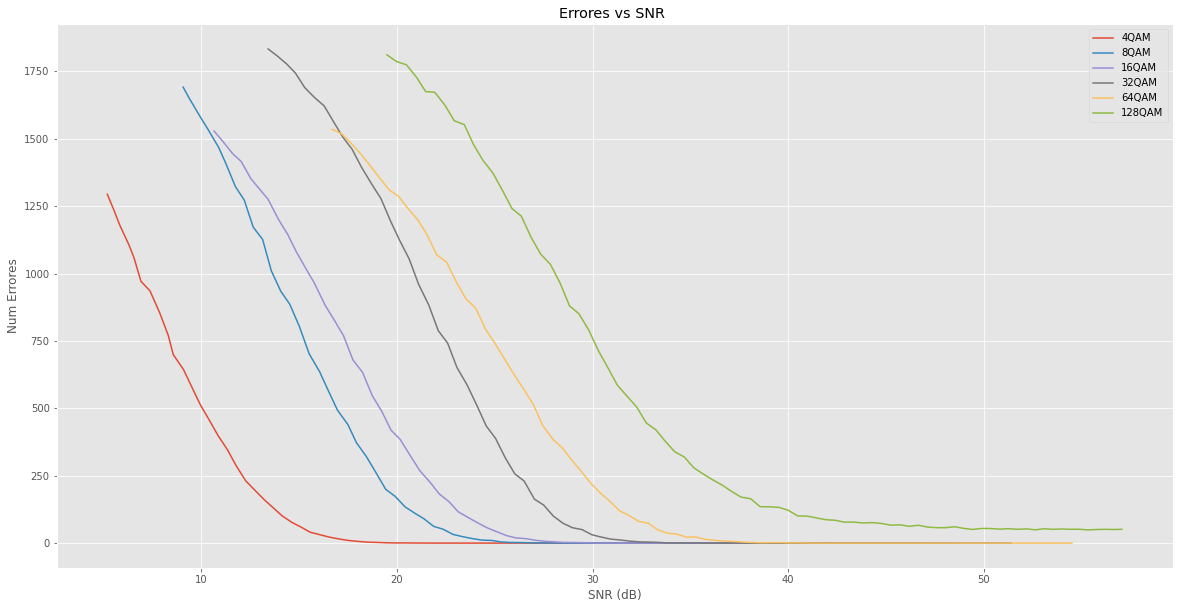

In [72]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.alpha=0
modulador.type_PAM='RRC'

Tables=[]
Labels=[]
for i in range(2,8):
  bit_grup=i  # numero de bits agrupados
  modulador.set_bitgrup(bit_grup)

  table = SNRvsErrores(modulador,5000,Repeticiones=10)

  Tables.append(table)
  Labels.append(str(modulador.order_mod)+'QAM')


grafica_SNRvsErrores(Tables,Labels)


Se realizaron las curvas de SNR. Recordando que el modulador realiza el mapeo de los bits descritos en la primer sección. Como se puede apreciar a medida que se utiliza un mayor orden de modulación esta es más sensible a la SNR


Ahora realizaremos un mapeo aletorio de los bits ver el efecto que este causa en las curvas

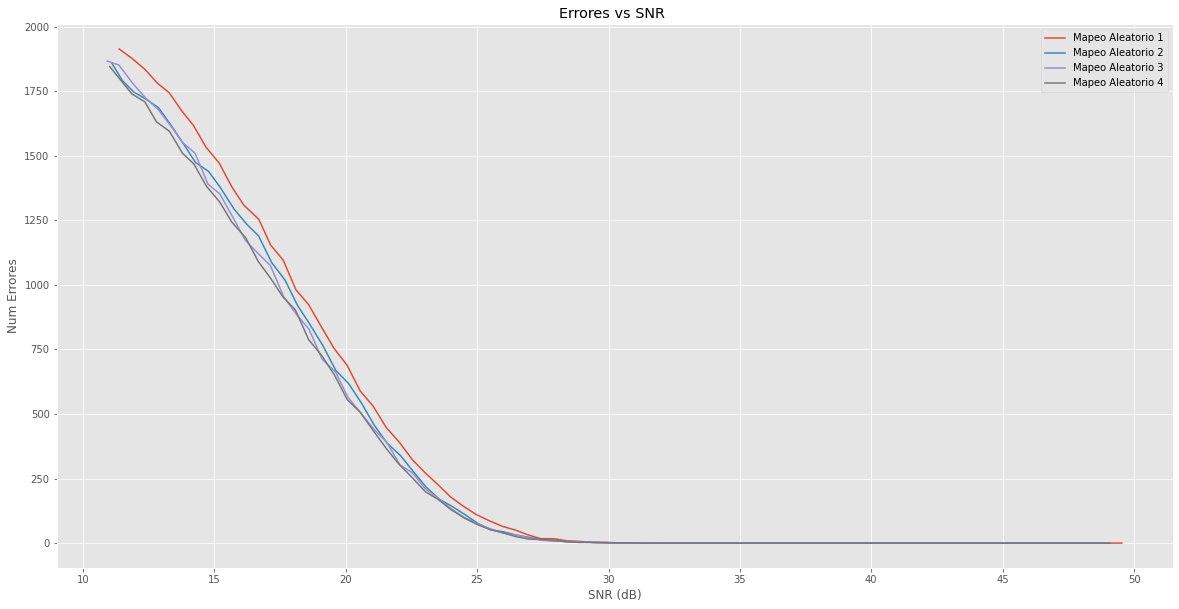

In [80]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.alpha=0
modulador.type_PAM='RRC'
bit_grup=4  # numero de bits agrupados  lo vamos a realizar para 16QAM total permutaciones 16P16 / 4 <- por la rotacion total de posibles permutaciones : 5.230697472e12
modulador.set_bitgrup(bit_grup)


Tables=[]
Labels=[]
for i in range(4):

  np.random.shuffle(modulador.table) #shuffle permuta los valores de un array aleatoriamente
  table = SNRvsErrores(modulador,5000,Repeticiones=10)

  Tables.append(table)
  Labels.append('Mapeo Aleatorio '+ str(i+1))


grafica_SNRvsErrores(Tables,Labels)

Con esta gráfica se ve el efecto que tiene el mapeo en la gráfica de errores versus la relación señal a ruido. Todas las gráficas disminuyen prácticamente hasta un mismo punto el cual es el SNR donde se pueden distinguir los símbolos. A partir de ese punto equivocarse en un símbolo o en otro es más costoso dependiendo de la distancia hamming de los puntos.


#Distancia Hamming 

La distancia hamming es el número de bits que cambia entre dos simbolos contiguos. ejemplo:

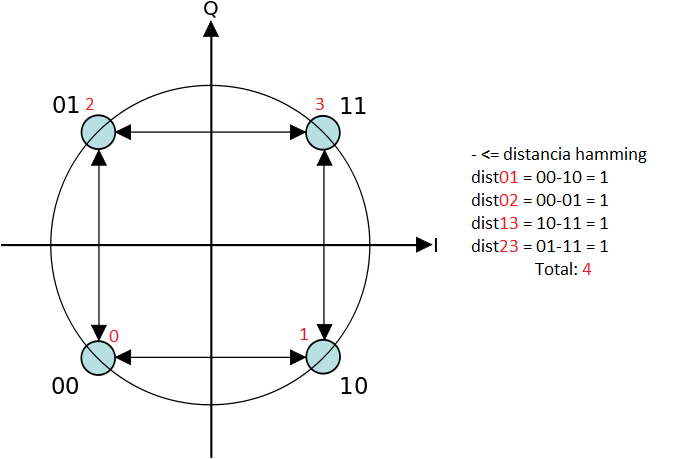

Cambiando el mapeo ahora la distancia hamming seria:

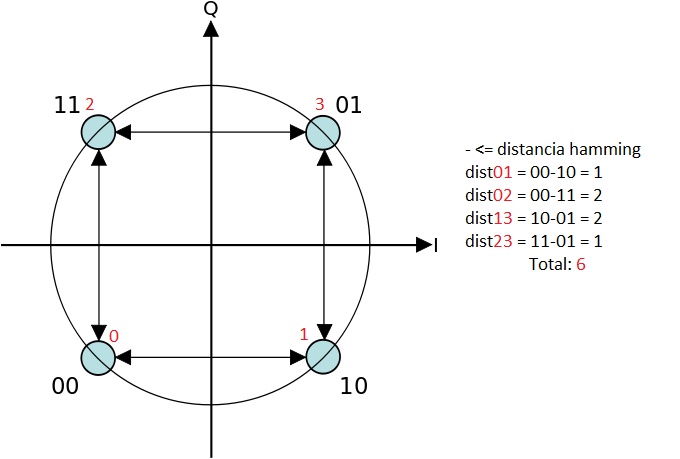

Con base en esto podemos implementar un algoritmo que calcule la distancia hamming para una modulación estandar en forma de cuadricula.

In [15]:
def dist_hamming(cod,table):
  bit_grup=int(np.log2(len(table)))
  table_bin = decimaltobin(table,bit_grup).reshape((-1,bit_grup)).astype('int')
  cod= list(cod)
  dist_cart = int(round(np.sum(np.power(cod[0]-cod[1],2)),1)*10)
  Total_hamming=0
  for i,point1 in enumerate(cod[:-1]):
    for k,point2 in enumerate(cod[i+1:]):
      dist_points= int(round(np.sum(np.power(point1-point2,2)),1)*10)
      if dist_points == dist_cart:
        dist_hamming = np.sum(np.abs(table_bin[i]-table_bin[k+i+1]))
        Total_hamming+= dist_hamming

  return Total_hamming

In [42]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.alpha=0
modulador.type_PAM='RRC'
bit_grup=4
modulador.set_bitgrup(bit_grup)

In [43]:
cod = modulador.cod
table = modulador.table

In [44]:
hamming = dist_hamming(cod,table)

print(hamming)

32


#Busqueda aletoria para encontrar dos mapeos que maximicen y minimicen la distancia hammnig para 16QAM


Con Base al algoritmo implementado se buscaran 2 mapeos aleatorios. Como es imposible evaluar todas las permutaciones posibles se hara en un numero de iteraciones dado

In [68]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2
modulador = QAM_Modulation(freq_por, time_bit, simbol_sample)
modulador.alpha=0
modulador.type_PAM='RRC'
bit_grup=4    # Si se modifica el numero de bits agrupados se puede calcular para cualquier QAM
modulador.set_bitgrup(bit_grup)
cod = modulador.cod
table = modulador.table



In [69]:
hamming = dist_hamming(cod,table)
print('Distancia Hamming inicial: '+ str(hamming))
min_table= np.copy(table)
max_table = np.copy(table)
max_hamming= hamming
min_hamming = hamming
Iter= 10000 # Numero de iteraciones

for i in range(Iter):
  np.random.shuffle(table)
  hamming = dist_hamming(cod,table)

  if hamming>max_hamming:
    max_table = np.copy(table)
    max_hamming= hamming
  if hamming<min_hamming:
    min_table= np.copy(table)
    min_hamming = hamming

print('Maxima Distancia Hamming encontrada: '+ str(max_hamming))
print('Minima Distancia Hamming encontrada: '+ str(min_hamming))


Distancia Hamming inicial: 32
Maxima Distancia Hamming encontrada: 67
Minima Distancia Hamming encontrada: 32


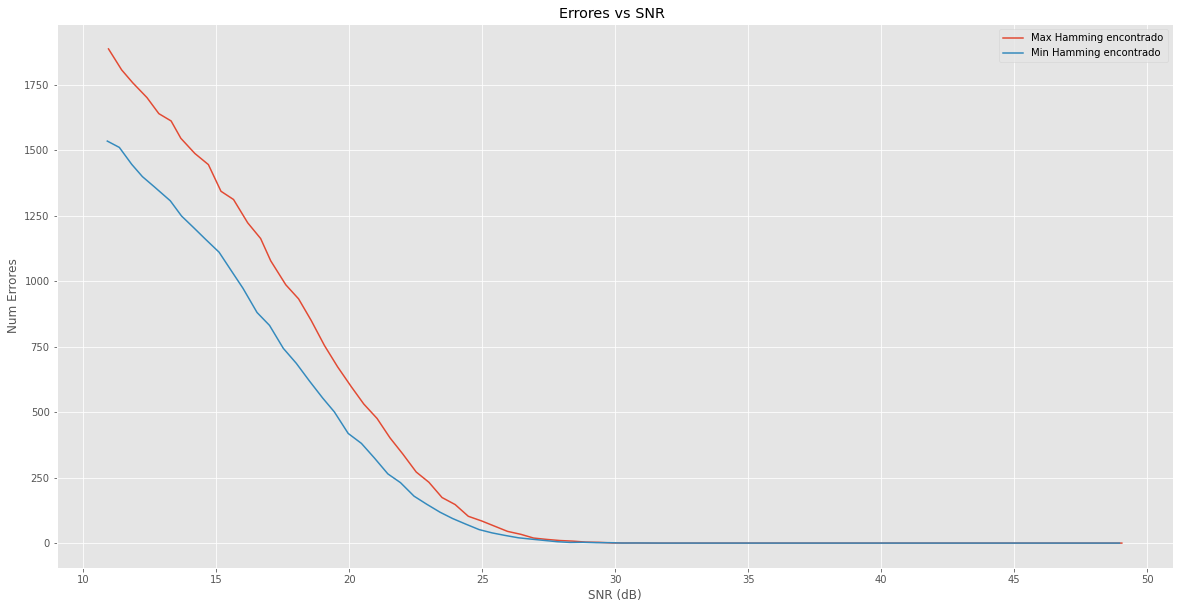

In [72]:
modulador.table = max_table
table1 = SNRvsErrores(modulador,5000,Repeticiones=10)
modulador.table = min_table
table2 = SNRvsErrores(modulador,5000,Repeticiones=10)

grafica_SNRvsErrores([table1,table2],['Max Hamming encontrado','Min Hamming encontrado'])

Como se esperaba la curva con el mapeo que tiene el mayor hamming esta por encima de la que tiene menor distancia hamming.

Tener una mayor distancia hamming en el mapeo es mejor para implementar algoritmos de detección automatica de errores. Si no se cuenta con estos algoritmos es mejor una distancia hamming pequeña.

#Modulaciones no convencionales

Para implementar una modulación no convencional basta con definir los puntos que queremos en el plano. 